In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

%matplotlib inline

In [2]:
data_raw = pd.read_csv("data/Hotel Reservations.csv")
data_raw.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# 1. Data Cleaning

**Dropping Columns to Omit**

In [3]:
rsvn = data_raw.drop(columns=['Booking_ID', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_special_requests'])

### Binary Columns
**1.1 Children Column**
make no_children => children (0 or 1 bianry)

In [4]:
def children(n):
    if n == 0:
        return 0
    else:
        return 1

In [5]:
rsvn['no_of_children'] = rsvn['no_of_children'].apply(children)
rsvn.rename(columns={'no_of_children': 'children'}, inplace=True)

### 1.2 Previous Cancellations Column
canceled reservations = no_of_previous_cancellations/(no_of_previous_cancellations+no_of_previous_bookings_not_canceled)

In [6]:
def get_canceled_rsvn_pcg(cancelled, not_cancelled):
    total = cancelled + not_cancelled
    if total == 0 : 
        return 0
    else: 
        return cancelled/total

rsvn['cx_rsvn_pcg'] = rsvn.apply(lambda x: get_canceled_rsvn_pcg(x.no_of_previous_cancellations, x.no_of_previous_bookings_not_canceled), axis=1)
rsvn.drop(columns=['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'], inplace=True)

### 1.3 Total Number of Nights Column
new column "total number of nights" = no_of_weekend_nights + no_of_week_nights

In [7]:
week_nights = rsvn['no_of_week_nights']
weekend_nights = rsvn['no_of_weekend_nights']
nights_ttl = week_nights + weekend_nights
rsvn['nights_ttl'] = nights_ttl
rsvn.drop(columns=['no_of_weekend_nights', 'no_of_week_nights'], inplace=True)

In [8]:
rsvn.head()

,no_of_adults,children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,avg_price_per_room,booking_status,cx_rsvn_pcg,nights_ttl
0,2,0,Meal Plan 1,0,Room_Type 1,224,Offline,0,65.00,Not_Canceled,0.0,3
1,2,0,Not Selected,0,Room_Type 1,5,Online,0,106.68,Not_Canceled,0.0,5
2,1,0,Meal Plan 1,0,Room_Type 1,1,Online,0,60.00,Canceled,0.0,3
3,2,0,Meal Plan 1,0,Room_Type 1,211,Online,0,100.00,Canceled,0.0,2
4,2,0,Not Selected,0,Room_Type 1,48,Online,0,94.50,Canceled,0.0,2


### 1.4 Target Column: Booking Status Column
Turn booking_status column to a binary column (Not canceled = 0, Canceled = 1)

In [9]:
def booking_status(s):
    if s == "Not_Canceled":
        return 0
    else:
        return 1
    
rsvn['booking_status']=rsvn['booking_status'].apply(booking_status)

rsvn_sum1 = rsvn.describe()[[True,True,True,True,False, False,False, True]]
rsvn_sum1

In [10]:
rsvn_sum2 = rsvn.info()
rsvn_sum2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_adults                36275 non-null  int64  
 1   children                    36275 non-null  int64  
 2   type_of_meal_plan           36275 non-null  object 
 3   required_car_parking_space  36275 non-null  int64  
 4   room_type_reserved          36275 non-null  object 
 5   lead_time                   36275 non-null  int64  
 6   market_segment_type         36275 non-null  object 
 7   repeated_guest              36275 non-null  int64  
 8   avg_price_per_room          36275 non-null  float64
 9   booking_status              36275 non-null  int64  
 10  cx_rsvn_pcg                 36275 non-null  float64
 11  nights_ttl                  36275 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 3.3+ MB


In [11]:
rsvn.head()

,no_of_adults,children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,avg_price_per_room,booking_status,cx_rsvn_pcg,nights_ttl
0,2,0,Meal Plan 1,0,Room_Type 1,224,Offline,0,65.00,0,0.0,3
1,2,0,Not Selected,0,Room_Type 1,5,Online,0,106.68,0,0.0,5
2,1,0,Meal Plan 1,0,Room_Type 1,1,Online,0,60.00,1,0.0,3
3,2,0,Meal Plan 1,0,Room_Type 1,211,Online,0,100.00,1,0.0,2
4,2,0,Not Selected,0,Room_Type 1,48,Online,0,94.50,1,0.0,2


In [12]:
names = ['no_of_adults', 'children', 'type_of_meal_plan',
       'required_car_parking_space', 'room_type_reserved', 'lead_time',
       'market_segment_type', 'repeated_guest', 'avg_price_per_room','cx_rsvn_pcg', 'nights_ttl']
interp = ['Number of adults',
          'Number of Children',
          'Type of meal plan booked',
          'Car parking space required',
          'Type of room reserved',
          'Gap b/w booking and arrival date',
          'Market segmentation',
          'Whether booked before no matter cancelled or not',
          'Average room price per day (in euros)',
          'History cancelling rate (in %)',
          'Number of nights stayed']
dtype = ['Int', 'Bin', 'Cate', 'Bin', 'Cate', 'Int', 'Cate', 'Bin', 'Con', 'Con', 'Int']
# range_level = rsvn.apply(pd.Series.nunique).values
rsvn_sum3 =  pd.DataFrame(
     {'col_name' : names,
      'interp' : interp,
      'dtp' : dtype,
      # 'range.or.level' : range_level
})
rsvn_sum3

,col_name,interp,dtp
0,no_of_adults,Number of adults,Int
1,children,Number of Children,Bin
2,type_of_meal_plan,Type of meal plan booked,Cate
3,required_car_parking_space,Car parking space required,Bin
4,room_type_reserved,Type of room reserved,Cate
5,lead_time,Gap b/w booking and arrival date,Int
6,market_segment_type,Market segmentation,Cate
7,repeated_guest,Whether booked before no matter cancelled or not,Bin
8,avg_price_per_room,Average room price per day (in euros),Con
9,cx_rsvn_pcg,History cancelling rate (in %),Con


In [13]:
numerical_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Int') | (rsvn_sum3['dtp'] == 'Con')]['col_name'].values
categorical_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Cate')]['col_name'].values
binary_columns = rsvn_sum3[(rsvn_sum3['dtp'] == 'Bin')]['col_name'].values

print(f'Numerical: {numerical_columns}\n Categorical: {categorical_columns} \n Binary: {binary_columns}')

Numerical: ['no_of_adults' 'lead_time' 'avg_price_per_room' 'cx_rsvn_pcg'
 'nights_ttl']
 Categorical: ['type_of_meal_plan' 'room_type_reserved' 'market_segment_type'] 
 Binary: ['children' 'required_car_parking_space' 'repeated_guest']


### Data Splitting

In [14]:
X = rsvn.drop(columns=["booking_status"]) 
y = rsvn.booking_status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.4 Preliminary analysis and results

The dimension of the cleaned data frame for analysis is 36275 x 12 which contains 5 numerical variables, 3 categorical variables and 4 binary variables including the target variable `booking_status`. 

It is notable that `cx_rsvn_pcg`, the rate of previous bookings that were canceled by the customer prior to the current booking, contains many missing values. This indicates the customer never ever booked this hotel before, no matter the booking was canceled or not, so the corresponding value for `repeated_guest` would be 0.

Some children booked this hotel without the accompanies by any adults which can be seen from `0` in `no_of_adults` with `1` in `children`. So it might also be meaningful to pay additional attention to the feedback from some adults with `children = 1` and see their satisfactory of the safety of this hotel.

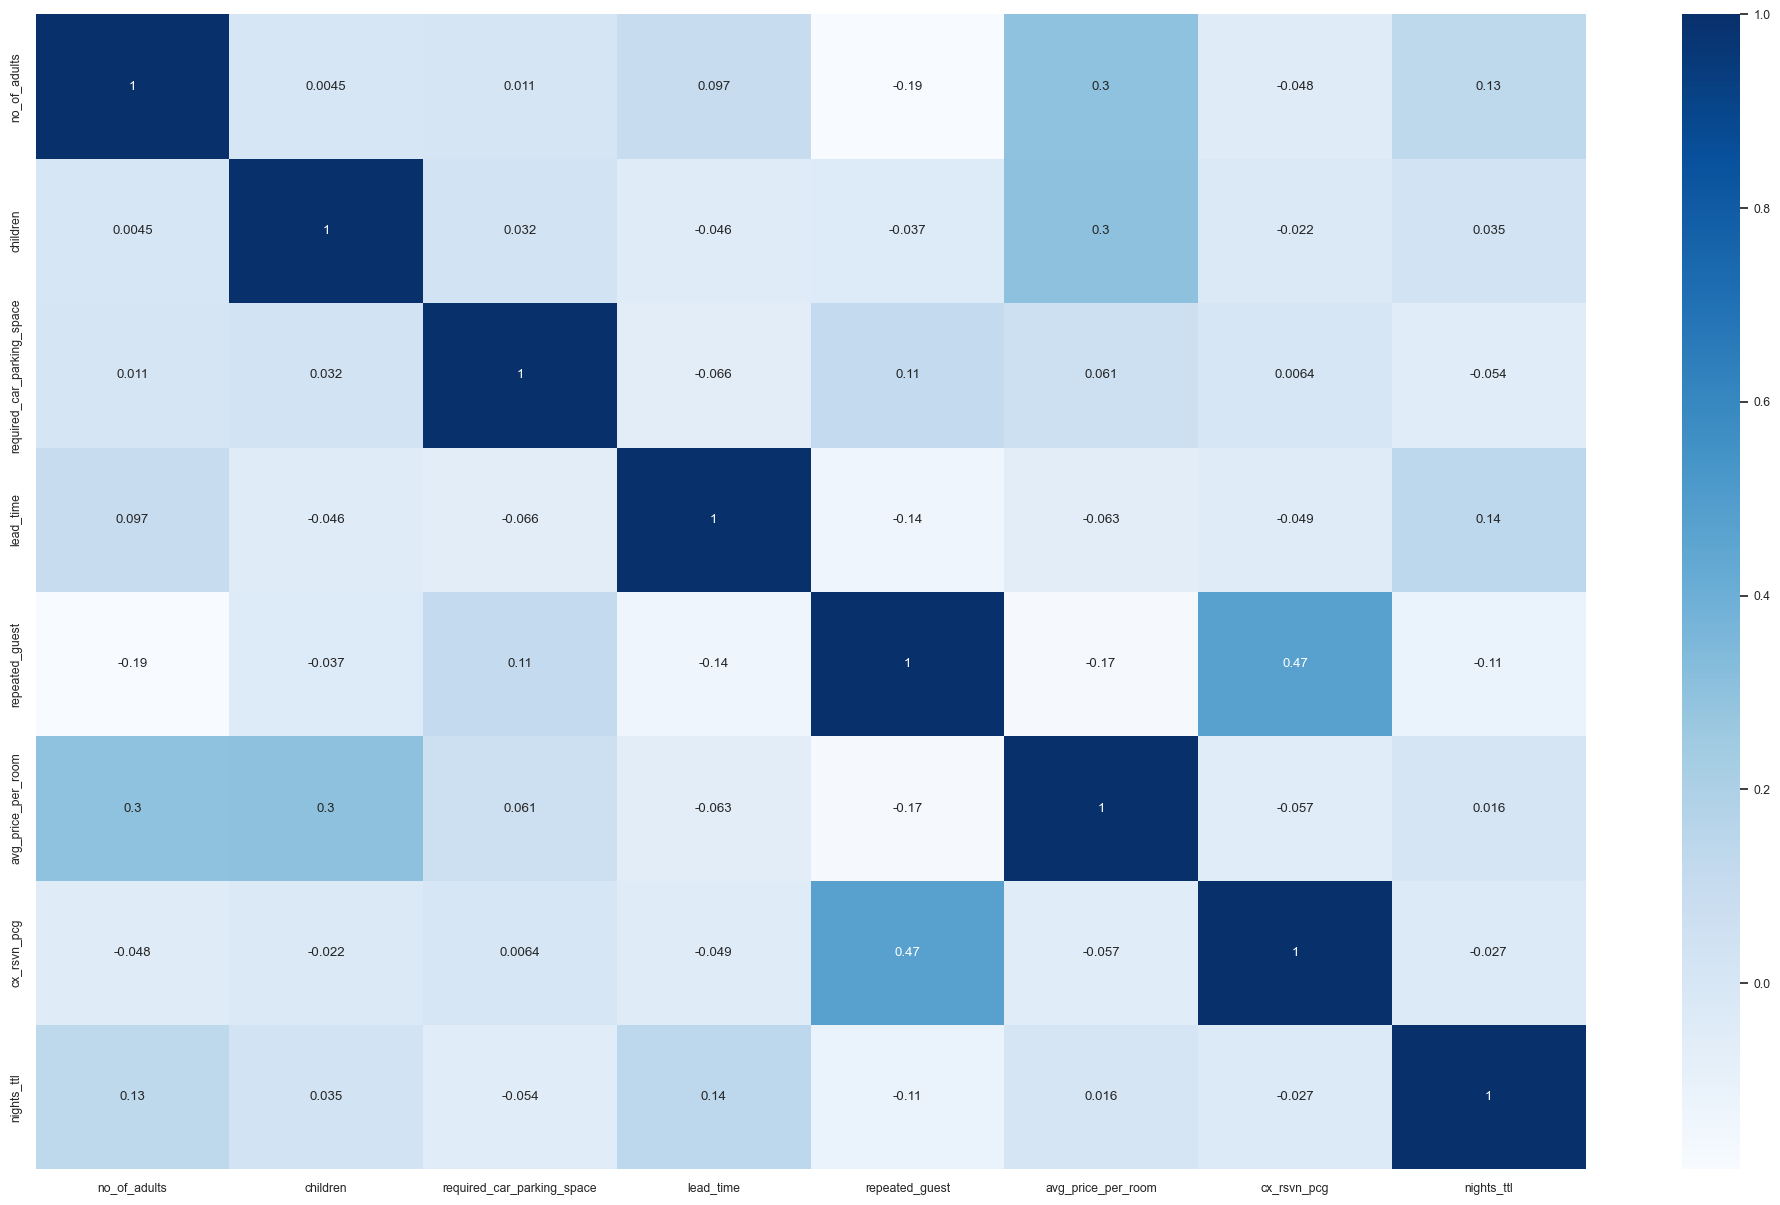

In [15]:
cor = X.corr()
plt.figure(figsize=(25, 15))
sns.set(font_scale=0.8)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

# Preprocessing

In [16]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

ct = make_column_transformer(
    (numeric_transformer, numerical_columns),
    (categorical_transformer, categorical_columns),
    ("passthrough", binary_columns)
)

transformed_df = pd.DataFrame(ct.fit_transform(X_train))
new_labels = ['no_of_adults', 'lead_time', 'avg_price_per_room', 'cx_rsvn_pcg', 'nights_ttl', 'meal_plan_1', 'meal_plan_2',
              'meal_plan_3', 'meal_not_selected', 'room type 1', 'room type 2' , 'room type 3', 'room type 4',  'room type 5',
              'room type 6', 'room type 7', 'aviation', 'complementary', 'corporate', 'offline', 'online',
              'children', 'required_car_parking_space', 'repeated_guest']
transformed_df.columns = new_labels

In [17]:
transformed_df

,no_of_adults,lead_time,avg_price_per_room,cx_rsvn_pcg,nights_ttl,meal_plan_1,meal_plan_2,meal_plan_3,meal_not_selected,room type 1,...,room type 6,room type 7,aviation,complementary,corporate,offline,online,children,required_car_parking_space,repeated_guest
0,0.300222,-0.691565,1.636392,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.300222,0.147033,0.512227,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.300222,4.048843,-0.953457,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.300222,1.276811,-0.889422,-0.076401,2.253093,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.627739,1.195281,0.754136,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,0.300222,-0.493562,-1.380355,-0.076401,0.559085,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29016,-1.627739,0.193622,-0.668858,-0.076401,-0.570254,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
29017,0.300222,-0.936156,0.184938,-0.076401,-0.570254,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29018,0.300222,1.486460,0.754136,-0.076401,-0.005584,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Variable Selection
Selecting the most important features to avoid overfitting on the entire training set

In [31]:
pipe_lr = make_pipeline(ct, LogisticRegression(solver='lbfgs', max_iter=1000))
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  array(['no_of_adults', 'lead_time', 'avg_price_per_room', 'cx_rsvn_pcg',
       'nights_ttl'], dtype=object)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  array(['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'],
      dtype=object)),
                                                 ('passthrough', 'passthrough',
                                                  array(['children', 'required_car_parking_space', 'repeated_guest'],
      dtype=object))])),
                ('logisticregression', LogisticRegression(max

In [35]:
import eli5

eli5.explain_weights(
    pipe_lr.named_steps["logisticregression"], feature_names=new_labels, top=30
)

Weight?,Feature
+1.345,aviation
+1.203,lead_time
+0.549,online
+0.532,avg_price_per_room
+0.521,meal_plan_3
+0.322,room type 1
+0.322,corporate
+0.215,room type 3
+0.171,room type 5
+0.145,room type 4


In [37]:
pipe_rf = make_pipeline(ct, RandomForestClassifier())
pipe_rf.fit(X_train, y_train)


eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=new_labels, top=30
)

Weight,Feature
0.5152 ± 0.0400,lead_time
0.3028 ± 0.0328,avg_price_per_room
0.0837 ± 0.0229,nights_ttl
0.0225 ± 0.0148,no_of_adults
0.0126 ± 0.0146,online
0.0090 ± 0.0125,offline
0.0085 ± 0.0019,required_car_parking_space
0.0062 ± 0.0070,meal_plan_2
0.0058 ± 0.0032,children
0.0052 ± 0.0056,meal_plan_1


In [39]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(max_depth=5))
pipe_dt.fit(X_train, y_train)

eli5.explain_weights(
    pipe_dt.named_steps["decisiontreeclassifier"], feature_names=new_labels, top=30
)

Weight,Feature
0.6854,lead_time
0.1726,avg_price_per_room
0.0866,online
0.0261,no_of_adults
0.0200,required_car_parking_space
0.0062,nights_ttl
0.0019,room type 1
0.0012,repeated_guest
0,room type 7
0,room type 6


Based on above results, we will drop columns meal plans, repeated guest, and children 

The most important ones seem to be
Lead time
Avg price per room
Market segment type

No of adults 

In [40]:
rsvn.drop(columns=["type_of_meal_plan", "repeated_guest","children"], inplace=True)

In [41]:
rsvn.head()

,no_of_adults,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,avg_price_per_room,booking_status,cx_rsvn_pcg,nights_ttl
0,2,0,Room_Type 1,224,Offline,65.00,0,0.0,3
1,2,0,Room_Type 1,5,Online,106.68,0,0.0,5
2,1,0,Room_Type 1,1,Online,60.00,1,0.0,3
3,2,0,Room_Type 1,211,Online,100.00,1,0.0,2
4,2,0,Room_Type 1,48,Online,94.50,1,0.0,2
